In [22]:
from rdkit.Chem import AllChem as Chem
import molellipsize as mes
import numpy as np
import stk
import glob

# From RDKit molecules over many conformers

In [3]:
dict_of_smiles = {
    'c6h6': 'c1ccccc1',
    'c6h12': 'C1CCCCC1',
    'c2': 'CC',
}

In [16]:
N = 10

c6h6 c1ccccc1
c6h12 C1CCCCC1
c2 CC


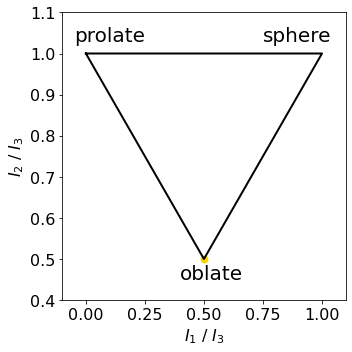

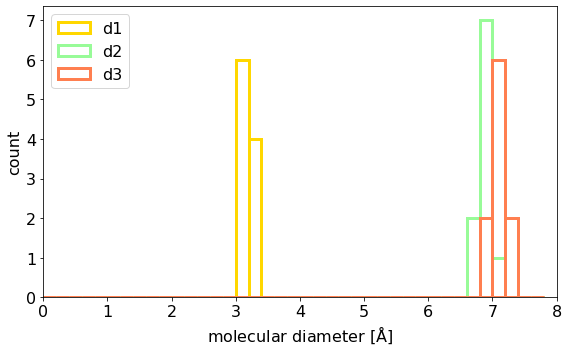

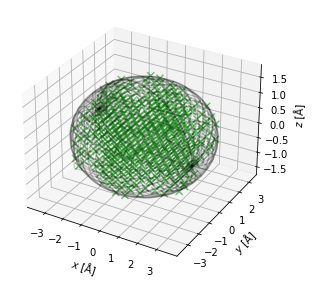

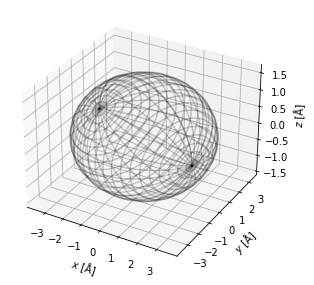

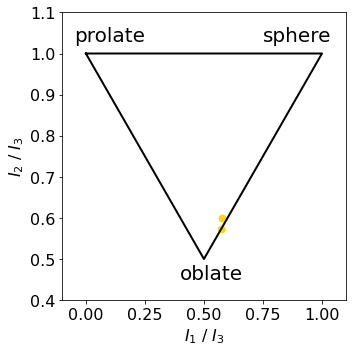

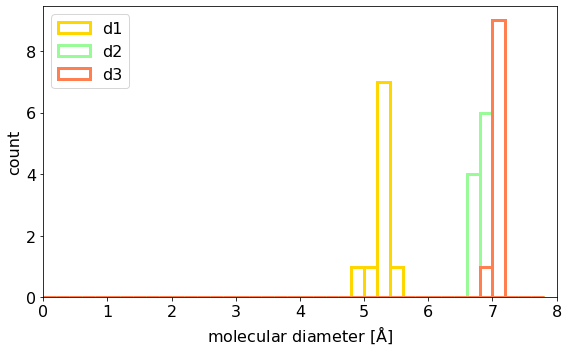

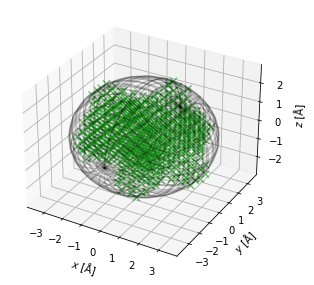

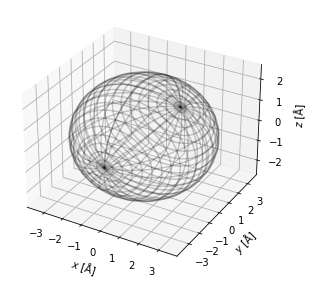

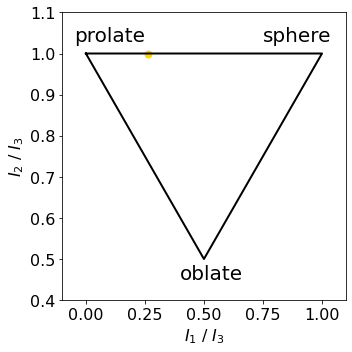

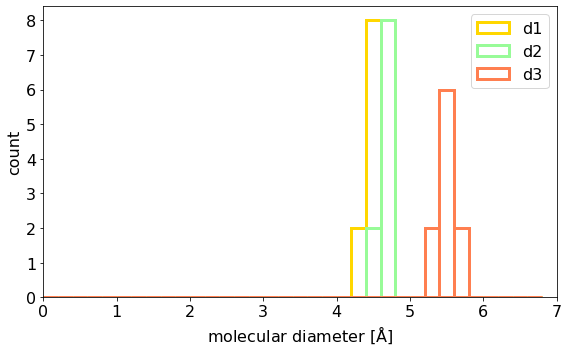

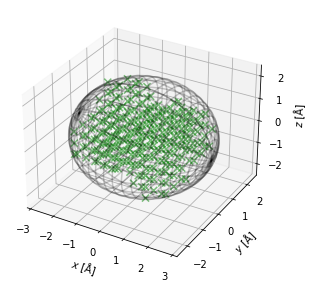

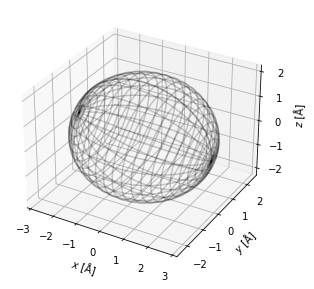

In [19]:
for name in dict_of_smiles:
    smiles = dict_of_smiles[name]
    print(name, smiles)
    rdkitmol = Chem.MolFromSmiles(smiles)
    rdkitmol = Chem.AddHs(rdkitmol)
    Chem.SanitizeMol(rdkitmol)
    rdkitmol, conformers = mes.ETKDG_UFF_conformers(
        rdkitmol=rdkitmol,
        num_conformers=N,
        randomseed=1000,
    )
    mes_mol = mes.Molecule(
        rdkitmol=rdkitmol,
        conformers=conformers,
    )
    ellipsoids = mes_mol.get_ellipsoids(
        boxmargin=4.0,
        vdwscale=0.9,
        spacing=0.5,
    )
    diameters = {i: ellipsoids[i][1] for i in ellipsoids}
    ratios = mes_mol.get_inertial_ratios()
    mes.plot_shapes(ratios, filename=f'{name}_shape.pdf')
    mes.plot_diameters(diameters, filename=f'{name}_size.pdf')
    
    # Pick an ellipsoid to draw.
    cid = 0
    center, diameter, rotation = ellipsoids[cid]
    mes_mol.draw_conformer_hitpoints(
        cid=cid,
        center=center,
        diameter=diameter,
        rotation=rotation,
        boxmargin=4.0,
        vdwscale=0.9,
        spacing=0.5,
        filename=f'{name}_ellhp.pdf',
    )
    fig, ax = mes.plot_ellipsoid(
        center=center,
        diameter=diameter,
        rotation=rotation,
    )
    fig.tight_layout()
    fig.savefig(f'{name}_ell.pdf', dpi=720, bbox_inches='tight')

# From an stk molecule.

In [13]:
# React the amine functional groups during construction.
bb1 = stk.BuildingBlock('NCCN', [stk.PrimaryAminoFactory()])
# React the aldehyde functional groups during construction.
bb2 = stk.BuildingBlock('O=CCCC=O', [stk.AldehydeFactory()])

# Build a polymer.
for i in range(1, 6):
    polymer = stk.ConstructedMolecule(
        topology_graph=stk.polymer.Linear(
            building_blocks=(bb1, bb2),
            repeating_unit='AB',
            num_repeating_units=i,
            optimizer=stk.Collapser(scale_steps=False),
        ),
    )
    mes_mol = mes.Molecule(polymer.to_rdkit_mol(), conformers=[0])
    ellipsoids = mes_mol.get_ellipsoids(
        boxmargin=4.0,
        vdwscale=0.9,
        spacing=0.5,
    )
    diameters = {i: ellipsoids[i][1] for i in ellipsoids}
    print(diameters)

{0: [5.205537759064478, 6.376035040476046, 12.516207344801591]}
{0: [5.451039106837794, 6.734612369757257, 24.607931976435516]}
{0: [5.603325489802962, 6.72926182551461, 38.31910093583731]}
{0: [5.680530040033388, 6.653642491406755, 52.34276537250901]}
{0: [5.74868383641504, 6.796363701895706, 64.77773039813262]}


# Using arbitrary coordinates to make an rdkit molecule.

In [15]:
# Using a Molecule.
# Fake the positions with C atoms, and some fake bonding.
atom_atomic_nums = [6, 6, 6, 6, 6, 6]
# Atom1 id, atom2 id, bond order.
bonds = [(0, 1, 1), (3, 4, 1)]
atom_positions = [
    [1, 0, 0], [-1, 0, 0],
    [0, 1, 0], [0, -1, 0],
    [0, 0, 1], [0, 0, -1],
]
# Make rdkit molecule.
mol = Chem.EditableMol(Chem.Mol())
for an in atom_atomic_nums:
    rdkit_atom = Chem.Atom(an)
    mol.AddAtom(rdkit_atom)

for bond in bonds:
    mol.AddBond(
        beginAtomIdx=bond[0],
        endAtomIdx=bond[1],
        order=Chem.BondType(bond[2]),
    )

mol = mol.GetMol()
rdkit_conf = Chem.Conformer(len(atom_atomic_nums))
for atom_id, atom_coord in enumerate(atom_positions):
    rdkit_conf.SetAtomPosition(atom_id, atom_coord)
    mol.GetAtomWithIdx(atom_id).SetNoImplicit(True)
mol.AddConformer(rdkit_conf)
# Hard set this.
conformers = [0]
mes_mol = mes.Molecule(mol, conformers)
conf_ratios = mes_mol.get_inertial_ratios()
conf_ellipsoids = mes_mol.get_ellipsoids(1.0, 4.0, 0.5)
center = conf_ellipsoids[0][0]
diameters = conf_ellipsoids[0][1]
print(
    f'This fake molecule makes a nice sphere at {center}'
    f' with diameters: {diameters} and inertial ratios '
    f'{conf_ratios[0]}'
)

This fake molecule makes a nice sphere at [-0.00105933 -0.0020292   0.00587181] with diameters: [5.10540721793702, 5.126227629406934, 5.194785267505398] and inertial ratios (1.0, 1.0)


# Without any molecule!!

In [14]:
# Without a molecule.
points = np.array([
    [1, 0, 0], [-1, 0, 0],
    [0, 1, 0], [0, -1, 0],
    [0, 0, 1], [0, 0, -1],
])
ET = mes.EllipsoidTool()
center, radii, rotation = ET.get_min_vol_ellipse(points)
print(
    f'These points make a nice sphere at {center}'
    f' with radii: {radii}'
)

These points make a nice sphere at [0. 0. 0.] with radii: [1. 1. 1.]


# Load from pore mapper example!

In [23]:
files = glob.glob('./poremapper_video/*_pore.xyz')
print(files)

['./poremapper_video/4D2_C_optc_pore.xyz', './poremapper_video/5B4_C_optc_pore.xyz', './poremapper_video/6C1_C_optc_pore.xyz', './poremapper_video/6A3_C_optc_pore.xyz']


In [33]:
for pore in files:
    pore_name = pore.replace('./poremapper_video/', '')
    # Read XYZ coordinates.
    coordinates = []
    with open(pore, 'r') as f:
        for line in f.readlines()[2:]:
            elem, x, y, z = line.rstrip().split()
            coordinates.append([float(x), float(y), float(z)])
    coordinates = np.array(coordinates)
    ET = mes.EllipsoidTool()
    center, radii, rotation = ET.get_min_vol_ellipse(coordinates)
    print(f'{pore_name} with radii: {radii}')

4D2_C_optc_pore.xyz with radii: [0.92705598 1.13341291 3.45867085]
5B4_C_optc_pore.xyz with radii: [3.23404401 4.58539335 5.6981495 ]
6C1_C_optc_pore.xyz with radii: [0.09999764 0.10000044 0.1000019 ]
6A3_C_optc_pore.xyz with radii: [0.09999697 0.10000129 0.10000173]
